### Для колаба

In [1]:
# Расскоментировать если запускаете в колаб
#!git clone https://github.com/MaximSinyaev/tutorials/
#!mv -f tutorials/lda_tutorial/*.png .
#!mv -f tutorials/lda_tutorial/*.jpg .
#!mv -f tutorials/lda_tutorial/*.csv .
#!mv -f tutorials/lda_tutorial/*.py .

<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dir_dist as dd

In [2]:
# Sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.manifold import TSNE

In [3]:
# External module imports
try:
    import pyLDAvis
    import pyLDAvis.sklearn
    pyLDAvis.enable_notebook()
except:
    !pip install pyldavis
    import pyLDAvis
    pyLDAvis.enable_notebook()

## Обзорная статья тематического моделировния

Сегодня рассмотрим два основных метода тематического моделирования LSA (Latent Semantic Analysis) Латентный семантический анализ и LDA (Latent Dirichlet Allocation) Латентное размещение Дирихле.
План сегодняшнего воркшопа:
1. Тематическое моделирование: что это такое и где можно использовать?
2. Разложение матриц и генерация тематик, как это связано?
    1. Мешок слов
    2. Разложение матриц
3. Латентное семантический анализ (LSA/LSI)
4. Вероятностное тематическое моделирование
    1. Латентный семантический анализ
    4. Латентное размещение Дирихле
5. Гиперпараметры и тюнинг моделей
6. Что дальше?


Помимо теории в данной статье будут представлены примеры, основанные на анализе отзывов для приложений по поиску работы, данные уже предобработаны (удалены знаки пунктуации и стоп слова, произведена лемматизация слов) и представляют собой датафрэйм с 2 колонками:
1. platform -  платформа
2. title_message_lemmatized - заголовок отзыва конкатенированный с текстом сообщения, все это очищенно и лемматизировано

**Особенности проблемы:** количество отзывов постоянно растет, а в случае активно развивающегося и конкурентного 
приложения необходимо оперативно определять проблемы потребителей и исправлять ошибки.

*Частично* данная задача решается с помощью тематического моделирования, которое позволяет выявить основные и наиболее распространенные тематики отзывов, которые после обработки можно интерпретировать вручную что обойдется намного дешевле для компании в отличии от ручной разметки, однако есть и минус, непопулярные и редкие проблемы могут потеряться, помимо этого могут возникнуть неинтерпретируемые категории (бессмысленные).

In [6]:
df = pd.read_csv('./bad_feedbacks_clean.csv').dropna()

In [7]:
df.head()

,platform,title_message_lemmatized
0,android,многий работать
1,android,обновление корректно отражаться раздел
2,android,запускаться 10 android обновление
3,android,максимальный количество скрытый вакансия 2000 ...
4,android,еле труд заполнить еле понимать писать один по...


### Тематическое моделирование: что это такое и где можно использовать?


**Задача**: имеется большое количество неразмеченных текстовых данных (корпус), необходимо найти часто встречаемые темы и распределить все документы к одной или нескольким темам.

**Решение**: векторизация текста с последующей кластеризацией полученного векторного представления данных.

> Данная задача может рассматриваться как задача одновременной кластеризации документов и слов по одному и тому же множеству кластеров, называемых темами. Обычно строится мягкая кластеризация, то есть документ может принадлежать нескольким темам в различной степени.
[\[1\]](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

Основным преимуществом тематического моделирования, как понятно из цитаты выше, является отсутствие необходимости в разметке данных, то есть применять данный метод можно на любом количестве данных и при удачном стечении обстоятельств (правильной обработке данных и выбора модели) получить результаты сравнимые с моделями классификации на размеченных данных.

**Прикладные задачи,** решаемые с помощью тематического моделирования:
- анализ коллекций научных статей;
- анализ новостных потоков;
- рубрикация коллекций изображений, видео, музыки;
- аннотация генома и другие задачи биоинформатики;
- коллаборативная фильтрация.

### Разложение матриц и генерация тематик, как это связано?
В этом разделе мы кратко рассмотрим как связаны матричные разложения и генерация тематик, а также векторизацию текстовых данных.

#### Мешок слов
Самым простым способом векторизации коллекции документов (коруса) является метод мешка слов. Суть метода: мы подсчитываем количество вхождений каждого слова для каждого документа, после чего строим матрицу, где в качестве строк представлены документы, а каждый столбец является словом, на пересечении находится число вхождений слова в документ.
Безусловно даже такому простому методу как "мешок слов" предшествует ряд необходимых операций, таких как очистка текста (от пунктуации и "мусорных слов"), токенизация (разбиение на минимально значащие фрагменты, в данном случае слова) и лемматизация/стемминг. Но сегодня не об этом, более подробно о векторизации текста приведена  в [\[2\]](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

In [8]:
# Создадим мешок слов с использованием CountVectorizer
vectorizer = CountVectorizer(max_df=0.5, min_df=3, ngram_range=(1,4)).fit(df['title_message_lemmatized'])
X_count = vectorizer.transform(df['title_message_lemmatized'])
terms = vectorizer.get_feature_names()

In [9]:
tfidf = TfidfTransformer().fit(X_count)
X_tfidf = tfidf.transform(X_count)

В результате получаем две разреженные матрицы, в X_count - хранится количество слов, в то время как в X_tfidf лежит матрица закодированная с использование частоты употребления слова (term frequency) и обратной частоты встречаемости в коллекции докумнтов (inverse docunent frequency).

In [10]:
print(f'Форма разреженных матриц {X_count.shape} (количество документов, количество используемых токенов)')

Форма разреженных матриц (3473, 3167) (количество документов, количество используемых токенов)


#### Разложение матриц

В машинном обучении большое распространение получили два алгоритма матричных разложений сингулярное разложение ([SVD](http://www.machinelearning.ru/wiki/index.php?title=%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5)) и факторизация неотрицательных матриц (NMF \[[1](http://www.machinelearning.ru/wiki/images/a/a8/NMF_NMU.pdf), [2](https://scikit-learn.org/stable/modules/decomposition.html#nmf), [3](https://habr.com/ru/post/264375/)\]).

Результатом матричного разложения является две матрицы меньших размеров, если исходная матрица (X) была размерности ($m x n$), то на выходе мы получаем следующие разложения:
1. SVD $X \approx X_k = U_k \sum_k V_{k}^T,$ где $k$ - количество вычисляемых компонент из полного SVD разложения (вычисляются самые значимые компоненты для приближения к исходной матрице)
2. NMF $X \approx W \cdot H$

Стоит отметить что метод NMF в отличии от SVD разложения может использовать для разложения матрицы вероятностный подход \[[2](https://scikit-learn.org/stable/modules/decomposition.html#nmf-with-a-beta-divergence)\] с использованием $\beta$-распределения.

Так как метод мешка слов дает нам матричное представление нашей коллекции документов, а методы разложения матриц являются хорошо проработанной задачей с большим количесвом решений, в том числе приведенных выше, то будет вполне логично применить матричное разложение для нашего корпуса.

*Что получится в результате разложения матричного представления корпуса?*

Как было упомянуто выше, в результате матричного разложения мы получаем две матрицы меньших размеров ($X_{m\tiny{\times}\normalsize n} = W_{m\tiny{\times}\normalsize r} \cdot H_{r\tiny{\times}\normalsize n}$), таким образом у нас появляется третья (скрытая) переменная которая связывает слова и документы, определяя принадлежность каждого документа к каждой скрытой переменной ($W$), и таким же образом соотнося каждое слово к одной из скрытых переменных ($H$).

Эти скрытые переменные и являются темами!

In [121]:
n_c = 3
np.random.seed(40)
x = np.random.randint(0, 10, size=(5,5))
x

array([[6, 7, 5, 8, 8],
       [2, 1, 7, 2, 3],
       [7, 3, 9, 0, 1],
       [5, 9, 8, 4, 4],
       [8, 6, 3, 3, 7]])

##### Иллюстрация усеченного сингулярного разложения
![TruncatedSVD.png](TruncatedSVD.png)

Разложим сгенерированную выше матрицу используя подход усеченного сингулярного разложения
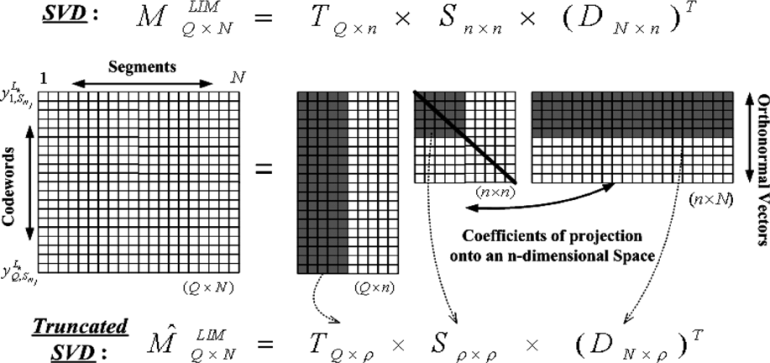

In [122]:
svd = TruncatedSVD(n_components=n_c)
u = svd.fit_transform(x)
v = svd.components_
print(f'Matrix U with shape{u.shape}\n{u}')
print(f'Matrix V* with shape{v.shape}\n{v}')

Matrix U with shape(5, 3)
[[14.68965881 -4.27778691 -1.45415965]
 [ 6.90861729  2.94420606 -2.12480127]
 [ 9.84526178  6.28697434  1.74470231]
 [13.7755514   0.99756526 -1.6339537 ]
 [12.13958435 -2.72991904  3.4080335 ]]
Matrix V* with shape(3, 5)
[[ 0.48290756  0.48179376  0.51182567  0.3194696   0.4130965 ]
 [ 0.09846333 -0.20737264  0.74183301 -0.43411729 -0.45664815]
 [ 0.76521307 -0.05539706 -0.38774839 -0.50900215  0.04413757]]


In [123]:
np.sum((x - u @ v) ** 2)

17.52113210139969

##### Неотрицательная матричная факторизация
![NMF.png](NMF.png)
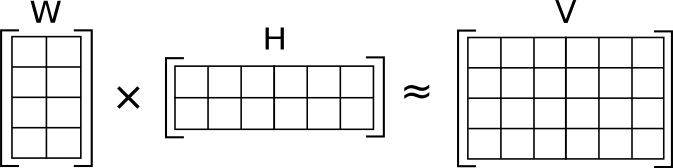

In [124]:
nmf = NMF(n_components=n_c)
u = nmf.fit_transform(x)
v = nmf.components_

In [125]:
print(f'Matrix U with shape{u.shape}\n{u}')
print(f'Matrix V* with shape{v.shape}\n{v}')

Matrix U with shape(5, 3)
[[2.97879226 0.         2.12309507]
 [0.80464303 1.81442699 0.        ]
 [0.         3.19746207 1.12221664]
 [2.04011889 1.79141859 1.22443575]
 [1.41897811 0.19144895 3.09984434]]
Matrix V* with shape(3, 5)
[[0.04748949 2.02489471 1.646009   2.41185402 1.74822437]
 [1.18700875 0.68445714 2.83490146 0.         0.        ]
 [2.56706994 0.99038368 0.         0.         1.27942881]]


In [126]:
np.sum((x - u @ v) ** 2)

17.816548422111282

### Латентный семантический анализ/индексирование (LSA/LSI)

Как уже упоминалось ранее под латентным семантическим анализом подразумеется разложение матрицы на две матрицы меньших размеров, произведение которых будет как можно ближе к исходной. Очевидно что у данной задачи имеется множество возможных решений, даже если зафксировать размерность скрытой переменной ($r$), в случае сингулярного разложения используются математические методы, которые позволяют итеративно находить наибольшие компоненты сингулярного разложения, продолжая до тех пор пор, пока не будет найдено заданное количество (количество тем).

Рассмотрим пример:

In [131]:
def get_topics_keywords(decompositor, terms, n_topics=None, n_keywords=8):
    '''
    Функция для вывода ключевых слов по топикам из матричного разложения
    '''
    topics = pd.DataFrame()
    for i, comp in enumerate(decompositor.components_[:n_topics]):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:n_keywords]
        topics = pd.concat([
            topics,
            pd.Series([f'{i[1]:.2} * ' + i[0] for i in sorted_terms], name=f'Topic#{i}'),
        ], axis=1)
    return topics

In [25]:
# Опытным путем было определенно что хороошие результаты с точки зрения интерпретации дает
# разбиение на 9 категорий
svd = TruncatedSVD(n_components=9, random_state=42, tol=1e-5)
X_svd = svd.fit_transform(X_tfidf)

In [26]:
X_svd[-2]

array([ 0.1146172 , -0.05411255, -0.07016916, -0.08644705, -0.0562935 ,
       -0.01420864, -0.04464311, -0.02512677, -0.02716041])

In [27]:
get_topics_keywords(svd, terms)

,Topic#0,Topic#1,Topic#2,Topic#3,Topic#4,Topic#5,Topic#6,Topic#7,Topic#8
0,0.39 * вакансия,0.89 * работать,0.53 * резюме,0.63 * работа,0.57 * город,0.58 * обновление,0.85 * очень,0.87 * полный,0.42 * один
1,0.31 * работать,0.13 * фильтр,0.16 * работа,0.24 * найти,0.25 * резюме,0.45 * вылетать,0.1 * плохо,0.27 * отстой,0.16 * объявление
2,0.27 * работа,0.1 * фильтр работать,0.16 * мочь,0.18 * город,0.21 * свой,0.17 * последний,0.1 * удобный,0.16 * шляпа,0.14 * работодатель
3,0.22 * город,0.062 * работать фильтр,0.15 * обновление,0.16 * найти работа,0.17 * свой город,0.16 * открываться,0.095 * ужасный,0.14 * полный отстой,0.11 * очень
4,0.21 * поиск,0.047 * обновление,0.12 * блокировать,0.11 * искать,0.17 * москва,0.16 * последний обновление,0.094 * очень плохо,0.077 * поиск,0.11 * такси
5,0.21 * резюме,0.046 * перестать работать,0.098 * модератор,0.096 * поиск работа,0.12 * показывать,0.12 * работа,0.092 * город,0.077 * бред,0.1 * тот
6,0.16 * фильтр,0.044 * перестать,0.086 * найти,0.094 * москва,0.099 * мой,0.098 * зайти,0.072 * интерфейс,0.077 * просто,0.097 * шляпа
7,0.16 * один,0.036 * работать работать,0.085 * ошибка,0.088 * искать работа,0.097 * выдавать,0.084 * мочь,0.069 * неудобный,0.058 * один,0.095 * найти


Одним из больших недостатков сингулярного разложения в контексте тематического моделирования является наличие отрицательных значений при разложении, что тяжело интерпретировать в контексте принадлежности документа к какому-то топику, также при использовании сингулярного разложения предполагается что слова и документы имеют нормальное распределение, что далеко от реальности.

In [28]:
nmf = NMF(n_components=9, max_iter=500, tol=1e-5)
X_nmf = nmf.fit_transform(X_tfidf)

In [29]:
X_nmf[-2]

array([0.06017269, 0.        , 0.00697079, 0.        , 0.        ,
       0.        , 0.00032133, 0.        , 0.        ])

In [30]:
get_topics_keywords(nmf, terms)

,Topic#0,Topic#1,Topic#2,Topic#3,Topic#4,Topic#5,Topic#6,Topic#7,Topic#8
0,3.0 * вакансия,2.2 * работать,1.6 * резюме,1.7 * работа,1.6 * город,1.4 * обновление,1.9 * очень,1.8 * полный,1.4 * один
1,0.7 * поиск,0.38 * фильтр,0.35 * блокировать,0.67 * найти,0.49 * москва,0.98 * вылетать,0.23 * плохо,0.54 * отстой,0.42 * объявление
2,0.25 * работодатель,0.25 * фильтр работать,0.34 * мочь,0.41 * найти работа,0.46 * свой,0.4 * последний,0.2 * очень плохо,0.3 * полный отстой,0.38 * такси
3,0.24 * поиск вакансия,0.16 * работать фильтр,0.29 * почему,0.31 * искать,0.43 * свой город,0.37 * последний обновление,0.19 * удобный,0.23 * шляпа,0.37 * тот
4,0.22 * который,0.1 * поиск,0.28 * модератор,0.27 * поиск,0.4 * показывать,0.37 * открываться,0.15 * неудобный,0.16 * бред,0.27 * один тот
5,0.21 * список,0.098 * перестать работать,0.28 * работодатель,0.25 * поиск работа,0.3 * фильтр,0.2 * зайти,0.15 * интерфейс,0.12 * просто,0.25 * водитель
6,0.2 * фильтр,0.089 * перестать,0.26 * мой,0.22 * искать работа,0.3 * выдавать,0.19 * стать,0.14 * удобно,0.093 * бред полный,0.2 * кадровый
7,0.2 * выдавать,0.088 * работать работать,0.23 * писать,0.18 * год,0.27 * другой город,0.18 * перестать,0.13 * хороший,0.086 * полный отсутствие,0.19 * вахта


При использовании обоих методов результаты оказались очень схожие, из ключевых слов видно что топик 0 посвящен проблеме с поиском вакансий, топик 1 связан с проблемами при фильтрации, а 2 топик с блокировкой резюме и проблемой с модерацией.

Среди данных двух методов предпочтение стоит отдать методу SVD, по причине скорости работы*:
```
# При равном занчении минимально допустимой погрешности (tol=1e-5)
>%timeit svd.fit_transform(X_tfidf)
21.2 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
>%timeit nmf.fit_transform(X_tfidf)
119 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
```
\* Однако при поиске оптимального подхода следует протестировать оба варинта, так как скорость зачастую является не определяющим фактором, но ограничивающим


#### Латентно-семантический анализ: итоги

*Преимущества:*
1. Быстрая скорость работы по сравнению с вероятносными методами.

*Недостатки:*
1. Существенным недостатком метода является значительное снижение скорости вычисления при увеличении объёма входных данных.
2. Как упоминалось ранее - вероятностная модель метода не соответствует реальности.

**Практическое применение:**
1. Сравнение документов (быстрое сравнение за счет уменьшения размерности)
2. Построение цепочек вида: слово/словосочетание - тема - документ (инверсная версия для поиска документов)

### Вероятностный латентно-семантический анализ
В основе приведенных выше методов ЛСА лежит матричное разложение (SVD и NMF), однако модели строятся из предположения что слова и документы имеют нормальное распределение, что является далеким от истины предположением.
В данном разделе будет рассмотрено два метода тематического моделирования:
1. Вероятностный ЛСА (pLSA)
2. Латентное размещение Дирихле

Прежде чем переходить к разбору примеров генерации тематик с помощью вероятностных методов слеует чуть поробнее остановиться на методе матричной факторизации (NMF) в основе метода лежит градиентный спуск, оптимизируется обычно дистанция $d$ между исходной матрицы $X$ и матричным произведением $W\cdot H$. Таким образом решается задача оптимизации функции
$$D(P, Q) =\sum_{i=1}^m\sum_{j=1}^n d(pij, qij)$$
> Во многих случаях дивергенция (функция потерь)  это замаскированное правдоподобие:существует такая функция плотности $p(P|Q)$,что
>
>$$-\ln p(P|Q) =aD(P, Q) +b$$
>
>для каких-то $a$ и $b$. \[[1](http://www.machinelearning.ru/wiki/images/a/a8/NMF_NMU.pdf)\]

В предыдущем разделе в качестве меры дистанции использовалась квадратичная норма Фробениуса, которая по своей сути является Евклидовой нормой, адаптированной для матриц $d_F(p, q) = (p-q)^2$. Таким образом порождающей моделью для распределения являлась аддитивная Гауссовская.

Однако распределение слов и документов ближе к Пуассоновской модели распределения, а функция ошибки (дивергенция) которая имеет Пуассоновскую порождающую модель является дивиргенция Кульбака-Лейбера $d_{KL}(p,q) = p\ln{\frac{p}{q}} - p + q$, больше информации и другие функции потерь \[[1](http://www.machinelearning.ru/wiki/images/a/a8/NMF_NMU.pdf)\].

![Poisson_distribution_PMF.png](Poisson_distribution_PMF.png)
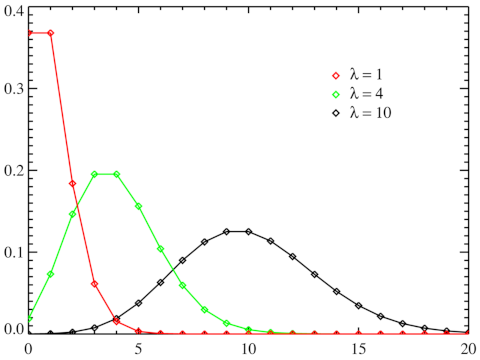

Изменив функцию оптимизации в задаче NMF мы получаем одну из реализаций pLSA.

Рассмотрим применение такого разложения на практике.

In [17]:
nmf_kl = NMF(n_components=9,
             beta_loss='kullback-leibler',
             solver='mu',
             max_iter=1000,
             alpha=.1,
             l1_ratio=.5)
X_nmf_kl = nmf_kl.fit_transform(X_tfidf)

In [31]:
get_topics_keywords(nmf_kl, terms)

,Topic#0,Topic#1,Topic#2,Topic#3,Topic#4,Topic#5,Topic#6,Topic#7,Topic#8
0,2.0 * вакансия,2.5 * работать,1.6 * резюме,2.1 * работа,1.6 * город,1.2 * обновление,1.6 * очень,1.0 * полный,0.91 * один
1,0.5 * поиск,0.67 * фильтр,0.4 * почему,0.85 * найти,0.66 * свой,0.72 * вылетать,0.61 * ужасный,0.62 * реклама,0.46 * объявление
2,0.33 * который,0.37 * фильтр работать,0.37 * блокировать,0.57 * искать,0.65 * показывать,0.55 * открываться,0.49 * удобный,0.59 * отстой,0.46 * работодатель
3,0.29 * работодатель,0.35 * норма,0.37 * модератор,0.42 * найти работа,0.62 * москва,0.41 * зайти,0.43 * интерфейс,0.55 * просто,0.42 * отзыв
4,0.27 * сделать,0.25 * перестать,0.33 * мочь,0.37 * поиск работа,0.59 * выдавать,0.36 * последний,0.41 * плохо,0.53 * поиск,0.38 * такси
5,0.27 * компания,0.24 * работать фильтр,0.31 * мой,0.35 * искать работа,0.39 * ставить,0.34 * постоянно,0.38 * неудобный,0.45 * шляпа,0.35 * регистрация
6,0.25 * искать,0.18 * перестать работать,0.29 * ваш,0.3 * поиск,0.38 * свой город,0.3 * стать,0.37 * хороший,0.44 * самый,0.31 * сайт
7,0.24 * другой,0.17 * поиск работать,0.27 * дать,0.29 * вахта,0.34 * весь,0.3 * заходить,0.33 * неудобно,0.41 * тупой,0.31 * писать


#### Латентное размещение Дирихле (LDA)
В основе метода LDA лежит следующая генерирующая модель \[[2](https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda)\]:
1. Выбирается количество слов в документе N (например из распределения [Пуассона](http://statistica.ru/theory/raspredelenie-puassona/))
2. Выбирается комбинация топиков для документа (исходя из предположения что все топики имеют распределение [Дирихле](http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/) \[[1](http://www.machinelearning.ru/wiki/images/f/f7/DirichletProcessNotes.pdf)\]), например если у нас всего два топика мы можем выбрать что 2/3 документа будет относиться к первому топику, а 1/3 ко второму топику.
3. В отдельности генерируется каждое слово:
    1. Сначала выбирается топик исходя из мультиномиального распределения, которое было сгенерировано в п. 2 (2/3, 1/3).
    2. Используется распределение вероятностей в топике чтобы сгенерировать из него слово, чем больше данное слово характеризует топик, тем больше вероятность его выбрать. $P(w|t)$

Исходя из приведенной модели генерации LDA пытается используя обратный ход отследить к какому топику и с какой вероятностью относится документ, перебирая каждое его слово.

**Важно!** Большим преимуществом LDA по сравнению с предыдущими моделями является возможность распределения документа по нескольким тематикам (см. п. 2 описания порождающей модели)

**Распределение Дирихле** - непрерывное распределение вероятностей, носителем которого является k-мерный симплекc $∆k={q∈Rk|∑ki=1qi= 1, qj≥0,j= 1,...,k}$

![dir_dist.jpg](dir_dist.jpg)
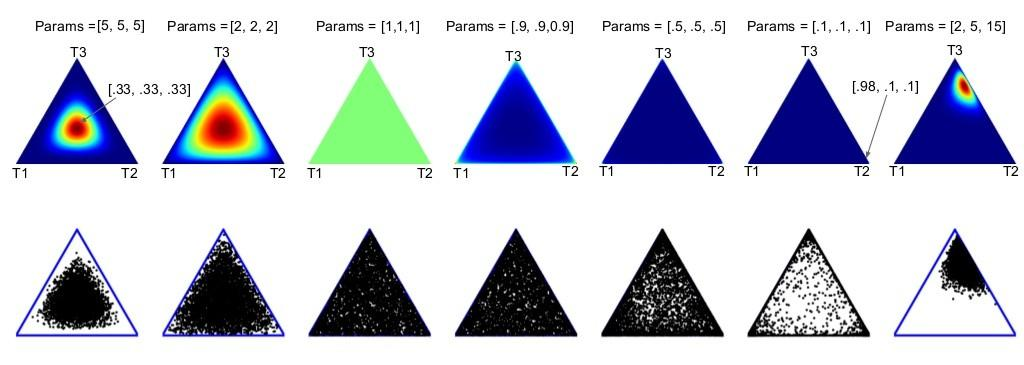

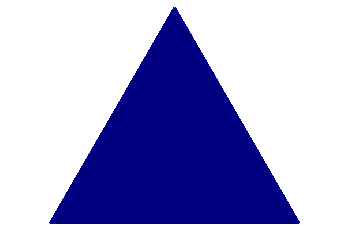

In [7]:
dd.draw_pdf_contours(dd.Dirichlet([0.33,0.33,0.33]))

**Обучение**

Обучение модели происходит следующим образом:
1. Сначала происходит инициализация распределения слов по топикам, путем случайного их распределения в результате чего получается модель которая уже может предсказывать номер вероятности принадлежности документа к каждому топику. Понятно что результаты этой модели никак не связаны с реальностью и являются случайными.
2. Следующий шаг это улучшения имеющейся модели. Для каждого имеющегося в коллекции слова:
    - Расчитывается
    $$P(T|w,D) = P(T|D) * P(w|T) = \frac{count\ of\ w\ in\ topic\ T * count\ of\ words\ in\ D\ that\ belong\ to\ T}{total\ count\ of\ words\ in\ T},$$
    где $P(T|W,D)$ - вероятность того что слово $w$ в документе $D$ относится к топику $T$.
3. После большого количества итераций мы получим модель латентного распределения, обученную различать тематики для различных документов.

Графическая модель генерирующей модели LDA \[[2](https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda)\]
![lda_model_graph.png](lda_model_graph.png)

- $D$ - коллекция документов
- $N$ - количество слов в докумене
- $K$ - количество топиков (скрытых переменных)

В рамки обведены повторяющиеся операции

In [137]:
%%time
lda = LatentDirichletAllocation(n_components=9,
                                doc_topic_prior=0.33,
                                batch_size=512,
                                max_iter=200,
                                max_doc_update_iter=100,
                                n_jobs=6,
                                random_state=42
                               )
X_lda = lda.fit_transform(X_count)

CPU times: user 2.89 s, sys: 263 ms, total: 3.15 s
Wall time: 38.7 s


Основные параметры:
- **n_componentsint, optional (default=10)** Number of topics.

- **doc_topic_priorfloat, optional (default=None)**
    Prior of document topic distribution theta. If the value is None, defaults to 1 / n_components. In [Re25e5648fc37-1], this is called alpha.
    
- **topic_word_priorfloat, optional (default=None)**
    Prior of topic word distribution beta. If the value is None, defaults to 1 / n_components. In [Re25e5648fc37-1], this is called eta.
    
- **learning_method‘batch’ | ‘online’, default=’batch’**
    Method used to update _component. Only used in fit method. In general, if the data size is large, the online update will be much faster than the batch update.

- **learning_decayfloat, optional (default=0.7)**
    It is a parameter that control learning rate in the online learning method. The value should be set between (0.5, 1.0] to guarantee asymptotic convergence. When the value is 0.0 and batch_size is n_samples, the update method is same as batch learning. In the literature, this is called kappa.
    
- **learning_offsetfloat, optional (default=10.)**
    A (positive) parameter that downweights early iterations in online learning. It should be greater than 1.0. In the literature, this is called tau_0.


In [138]:
get_topics_keywords(lda, terms, n_keywords=10)

,Topic#0,Topic#1,Topic#2,Topic#3,Topic#4,Topic#5,Topic#6,Topic#7,Topic#8
0,2.7e+02 * работать,4.8e+02 * вакансия,2.9e+02 * резюме,3.1e+02 * вакансия,1e+02 * который,2.4e+02 * работа,4.1e+02 * город,3.8e+02 * работа,4e+02 * резюме
1,2.2e+02 * обновление,3.2e+02 * один,1.1e+02 * опыт,3.1e+02 * работодатель,9.1e+01 * время,2.1e+02 * найти,2.9e+02 * фильтр,1.3e+02 * искать,1.2e+02 * мой
2,1.3e+02 * ошибка,1.2e+02 * очень,1e+02 * каждый,1.3e+02 * отзыв,9e+01 * полный,9.1e+01 * реклама,2.2e+02 * вакансия,1.3e+02 * вакансия,9.4e+01 * модератор
3,1e+02 * пароль,1.1e+02 * поиск,8.4e+01 * мочь,9.8e+01 * отклик,8.2e+01 * весь,7.1e+01 * год,2.1e+02 * поиск,1.2e+02 * поиск,9.3e+01 * блокировать
4,9.6e+01 * мочь,1.1e+02 * тот,8.2e+01 * день,8.8e+01 * возможность,7.3e+01 * очень,6.8e+01 * найти работа,1.9e+02 * показывать,9.8e+01 * предлагать,7.1e+01 * свой
5,8.8e+01 * вылетать,9.9e+01 * такси,8e+01 * сайт,8.6e+01 * компания,6.4e+01 * просто,5.4e+01 * программа,1.6e+02 * работать,8e+01 * поиск работа,6.9e+01 * постоянно
6,8.1e+01 * войти,7e+01 * другой,5.9e+01 * телефон,8.4e+01 * который,5.6e+01 * личный,5.1e+01 * сделать,1.6e+02 * выдавать,6.7e+01 * другой,4.9e+01 * почему
7,7.8e+01 * писать,6.9e+01 * водитель,5.9e+01 * создать,6.1e+01 * объявление,5.4e+01 * почта,5e+01 * hh,1.4e+02 * москва,6.5e+01 * один,4.8e+01 * мой резюме
8,7.3e+01 * зайти,6.2e+01 * объявление,5.7e+01 * опыт работа,5.8e+01 * такой,5.3e+01 * отстой,4.2e+01 * разработчик,1.1e+02 * ставить,6.5e+01 * предложение,4.8e+01 * заблокировать
9,6.8e+01 * постоянно,5.9e+01 * кадровый,5.6e+01 * номер,5.4e+01 * соискатель,5.2e+01 * пока,4.1e+01 * хороший,1e+02 * свой,6.1e+01 * место,4.6e+01 * писать


Сравним с категориями, которые были проставлены вручную и обобщены людьми:
1. Проблемы с вакансиями
1. Проблемы с рассылкой
1. Фильтр/поиск
1. Сбои, проблема с приложением
1. Проблемы с интерфейсом
1. Проблемы с работодателем
1. Модерация
1. Ничего не нашел
1. Другое

Большм недостатком всех приведенных в данном обзоре моделей является пренебрежение порядком слов, что характерно для методов МО использующих для векторизации мешок слов.

### Тюнинг моделей
В случае с NLP и использованием моделей на базе мешка слов самым важным этапом является подготовка данных, при правильной подготовке данных даже при дефолтных гиперпараметрах модели показывают хороший результат, который потом можно улучшить уже с помощью тюнинга гперпараметров. Однако важно понимать что во всех приведенных в данном обзоре моделях тематического моделирования используются численные методы разложения матриц, исходя из различных предположений о природе данных. Поэтому здесь сложно дать какие-то универсальные рекомендации. Но вот что вам точно поможет:
1. Использование биграм/триграмм
2. После полного цикла обработки данных и получения разбиения необходимо исследовать кластеры на стопслова, характерные именно для ваших данных. Например в рассматриваемых данных список стоп-слов был расширен ругательтвами и словами "приложение" и "вакансия", так как эти слова были неинформативны либо по отсутствию информации, либо по причине присутствия во всех кластерах.
3. Протестировать другие модули для LDA (gensim, bigartm, $\dots$)
4. Попытаться вручную разметить часть имющихся данных и сравнить разбиение с LDA.

Что можно улучшить:
1. Исключить одинаковые по значению биграммы "перестать работать" и "работать перестать"
2. Протестирова semi-supervised LDA
3. Пойти дальше и не зацикливаться на LDA $:)$

#### Визуализация результатов
Для визувлизации можно использовать уменьшение размерности полученной матрицы (снова) и вынесении имеющихся документов на двумерную плоскость.

Однако в python есть модуль который может ускорить это процесс и предоставить удобную для отчетов визуализацию [pyLDAvis](https://pypi.org/project/pyLDAvis/)

In [24]:
pyLDAvis.sklearn.prepare(lda, X_count, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.225762 -0.086344       1        1  15.159372
3      0.024484  0.133782       2        1  14.335252
0      0.154952 -0.256799       3        1  12.489003
2      0.106407  0.115955       4        1  11.334852
4      0.063130  0.004005       5        1  11.257458
8      0.163834  0.041724       6        1  10.891122
1     -0.182576 -0.022672       7        1   8.904245
7     -0.117069  0.057300       8        1   8.748910
5      0.012599  0.013049       9        1   6.879786, topic_info=              Term         Freq        Total Category  logprob  loglift
2401        резюме   641.000000   641.000000  Default  30.0000  30.0000
526          город   380.000000   380.000000  Default  29.0000  29.0000
167       вакансия  1097.000000  1097.000000  Default  28.0000  28.0000
3037        фильтр   275.000000   275.000000  Default  27.0000  27.0000
2291  работодатель   295.000000   295.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
2017        почему    16.379861   154.158347   Topic9  -5.1906   0.4347
371    возможность    14.688708    83.380451   Topic9  -5.2996   0.9402
2531          свой    15.427371   204.222492   Topic9  -5.2505   0.0935
475       вылетать    13.605393    81.697347   Topic9  -5.3762   0.8840
1495          один    13.912100   360.060014   Topic9  -5.3539  -0.5769

[610 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
19        8  0.902502     15 минута
38        8  0.902502          3500
71        1  0.029976         авить
71        5  0.029976         авить
71        6  0.239806         авить
...     ...       ...           ...
3146      9  0.080288         шляпа
3160      6  0.915881          язык
3163      1  0.836630        яндекс
3163      5  0.167326        яндекс
3165      1  0.936523  яндекс такси

[1222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 1, 3, 5, 9, 2, 8, 6])

### Что дальше?
Так как  LDA является верхушкой айсберга тематического моделирования, то на данный момент мне видится два развития/продолжения этой статьи:
1. Изучение и анализ специализированных модулей и библиотек, как [mallet](https://radimrehurek.com/gensim/models/wrappers/ldamallet.html) и [bigARTM](https://bigartm.readthedocs.io/en/stable/) \[[1](http://www.machinelearning.ru/wiki/index.php?title=BigARTM)\]
2. Тестирование и проверка эффективности semi-supervised версий LDA ([CorEx](https://github.com/gregversteeg/corex_topic), [Guided LDA](https://github.com/vi3k6i5/GuidedLDA))

### Список для чтения по тематическому моделированию и LDA
Для того чтобы разобраться в тематическом моделирование я успел озакомиться с большим количеством статей, для того чтобы глубже разобраться в Латентном размещении Дирихле и порождающих моделях могу порекомендовать:
1. Хабр
    1. [Цикл статей по вероятностным моделям](https://habr.com/ru/company/surfingbird/blog/228249/)
    1. [Статья посвященная обработке естественных языков](https://habr.com/ru/company/mailru/blog/358736/)
    1. [Развитие моделей для тематического моделирования](https://habr.com/ru/company/yandex/blog/313340/)
2. [Topic modeling made just simple enough](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/)
3. [Introduction to Latent Dirichlet Allocation](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)

### Список источников
1. [Machinelearning wiki](http://www.machinelearning.ru)
2. [sklearn documentation](https://scikit-learn.org/)
3. [habr](https://habr.com/ru)